# Index
* [Import](#index)
* [Tokenization](#Tokenization)
* [CountVectorizer](#CountVectorizer)
* [PreprocessPipeline](#PreprocessPipeline)
* [OvsRest](#OvsRest)
    - [LogisticRegression](#LogisticRegression)
    - [SVC](#SVC)
* [Word2Vec](#Word2Vec)
* [BERT](#BERT)
* [USE](#USE)
* [LDA](#LDA)

In [1]:
import time
import json
import os

# from joblib import dump, load, Memory
import joblib
import dill
import weakref

# import warnings

import numpy as np
import pandas as pd
import gensim
import pyLDAvis
import matplotlib.pyplot as plt

# from gensim import (
#     corpora,
# )  # https://pypi.org/project/gensim/ #https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html#sphx-glr-auto-examples-core-run-topics-and-transformations-py
from sklearn import (
    metrics,
    feature_extraction,
    linear_model,
    model_selection,
    preprocessing,
    cluster,
    decomposition,
    multiclass,
    svm,
    pipeline,
    exceptions,
    manifold,
)
from wordcloud import WordCloud
from sklearn.utils._testing import ignore_warnings
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
import tensorflow_hub as hub
from transformers import (
    AutoTokenizer,
    TFAutoModel,
    AutoModel,
    BertTokenizer,
    TFBertModel,
    BertConfig,
)  # BertModel
import transformers
from tokenizers import BertWordPieceTokenizer


# import nlpk

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Dep

In [2]:
from kerasembedtransformerclass import p5_nlp_utils

/opt/conda/lib/python3.7/site-packages/mxnet/numpy/utils.py:37: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bool = onp.bool
/opt/conda/lib/python3.7/site-packages/mxnet/numpy/fallback.py:143: DeprecationWarning: In accordance with NEP 32, the function mirr was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  mirr = onp.mirr
/opt/conda/lib/python3.7/site-packages/mxnet/numpy/fallback.py:160: DeprecationWarning: In accordance with NEP 32, the function npv was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial libr

https://scikit-learn.org/stable/modules/multiclass.html test autre stategie que OneVsRest  
https://keras.io/examples/nlp/text_extraction_with_bert/  

In [3]:
pip install -q jupyter-black jupyter

Note: you may need to restart the kernel to use updated packages.


In [4]:
# for black formating
import jupyter_black  # pip install jupyter-black jupyter

jupyter_black.load()
# ??jupyter_black.load #show config

In [5]:
df = pd.read_csv(
    "/kaggle/input/p5-nlp/stackoverflowCleanedV2.csv", index_col=0, low_memory=False
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118442 entries, 0 to 118441
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Id           118442 non-null  int64 
 1   Title        118442 non-null  object
 2   Body         118442 non-null  object
 3   0            118440 non-null  object
 4   1            118383 non-null  object
 5   2            118292 non-null  object
 6   3            118292 non-null  object
 7   4            76389 non-null   object
 8   5            4 non-null       object
 9   Token_lemma  118442 non-null  object
 10  Token_BERT   118442 non-null  object
 11  code         88202 non-null   object
dtypes: int64(1), object(11)
memory usage: 11.7+ MB


In [6]:
LONG = False
description = {
    "title": "Word2Vec best scores",
    "target_min_freq": 0.002, # 0.002 -> 50tags jusqu'a git
    "target_nb_max": 20, # int en complément de freq, premier test fait avec 20+git
    "CountVectorizer": {"min_df": 0.00001, "max_df": 0.995, "max_features": None},
    "StandardScaler": {"actif": False},
    "TruncatedSVD": {"actif": False, "n_components": 1_000},
    "LogisticRegression": {"actif": False},
    "TfidfOvRSVC": {"actif": False, "max_iter": 100},
    "Word2Vec_keras": {
        "actif": True,
        "TextVectorization__max_tokens": 210_000,  # 20_000,
        "TextVectorization__output_sequence_length": 256,  # max tokens(mots) considéré par question #20
        "Embedding__output_dim": 512, 
        "Word2Vec__min_count": 5,
        "Word2Vec__window": 25,
        "Word2Vec__epochs": 200,  # 100,
        "fit__learning_rate":1e-5,
        "fit__epochs": 150,  # 15
    },
    "Word2Vec_OVR": {
        "actif": False,
        "min_count": 1,
        "size": 500,
        "window": 10,
        "epochs": 100,
        "maxlen": 50,
        "max_iter": 6_000,
    },
    "BERT": {
        "actif": False,
        "max_length": 512,
        "epochs": 10,
        "cleaning":"v2",
    },
    "USE": {"actif": False, "tsne_visu": True, "epochs": 50},
    "LDA": {
        "actif": False,
        "num_topics": [20],  # [5, 10, 20],
        "lda__no_below": 100,
        "lda__no_above": 0.5,
        "lda__max_tokens": 100_000,
        "lda__iterations": 50,
        "word_cloud__nb_words": 50,
    },
}

In [7]:
class colors:
    PURPLE = "\033[95m"
    BLUE = "\033[94m"
    CYAN = "\033[96m"
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

# Tokenization

In [8]:
from ipywidgets import interact


@interact(i=(0, df.shape[0] - 1))
def test_tr_print(i):
    print(
        f'***Title***{df["Title"][i]}\n{"*"*30}\n***Body***{df["Body"][i]}\n{"*"*30}\n\
        ***Lemma** {df["Token_lemma"][i]}\n{"*"*30}\n\
        ***Bert*** {df["Token_BERT"][i]}\n{"*"*30}\n\
        ***Code*** {df["code"][i]}\n{"*"*30}\n\
        ***Tags*** {df.loc[i,"0"]} {df.loc[i,"1"]} {df.loc[i,"2"]} {df.loc[i,"3"]} {df.loc[i,"4"]}'
    )

/opt/conda/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:13: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  DeprecationWarning,


interactive(children=(IntSlider(value=59220, description='i', max=118441), Output()), _dom_classes=('widget-in…

In [9]:
print(sum(df["Token_lemma"].isna()))
df[df["Token_lemma"].isna()][
    ["Title", "Body", "Token_lemma", "0", "1", "2", "3", "4"]
].head(5)

0


,Title,Body,Token_lemma,0,1,2,3,4


In [10]:
print(sum(df["Token_BERT"].isna()))
df[df["Token_BERT"].isna()][
    ["Title", "Body", "Token_BERT", "code"]
].head(5)

0


,Title,Body,Token_BERT,code


In [11]:
tags = df[["0", "1", "2", "3", "4", "5"]].stack()
target_names = [
    tag
    for tag, freq in tags.reset_index(drop=True).value_counts(normalize=True).items()
    if freq > description["target_min_freq"]
]
if description["target_nb_max"] and len(target_names)>description["target_nb_max"]:
    target_names = target_names[0:description["target_nb_max"]] + ["git"]
print(f"taille {len(target_names)}\n{' '.join(target_names)}")

taille 21
java c# javascript python android c++ ios html php .net jquery css objective-c c sql iphone asp.net mysql linux node.js git


In [12]:
# Enregistrement des paramétres avec la liste des tags a predire
description["target_names"] = target_names
with open("/kaggle/working/description.json", "w") as outfile:
    json.dump(description, outfile)

In [13]:
p5_nlp_utils.Commun.tags_are_in(
    df[0:10], ["javascript", "java", "c#", "python", "html", "git", "php"]
)

,javascript,java,c#,python,html,git,php
0,False,True,False,False,False,False,False
1,False,False,False,False,False,True,False
2,False,False,False,False,False,True,False
3,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False
6,False,False,False,False,False,True,False
7,True,False,False,False,False,False,False
8,True,False,False,False,False,False,False
9,False,False,False,True,False,False,False


## Separation train/test

In [14]:
if description["BERT"]["actif"] and description["BERT"]["cleaning"] =="raw": #essaie sans nettoyer le texte pour BERT
    df["Token"] = (
        df["Title"].fillna("").str.strip() + " " + df["Body"].fillna("").str.strip()
    )
elif description["BERT"]["actif"] and description["BERT"]["cleaning"] =="v2":
    df["Token"] = df["Token_BERT"]
else:
    df["Token"] = df["Token_lemma"]
#     df["Token"] = df["Title_clean"].fillna("") + df["Body_clean"].fillna("")
    print(
        f"{len(df[[len(token.split()) > 1 for token in df['Token']]])/len(df):.5%} des questions ont au moins 2tokens"
        if len(df[df["Token"] == ""]) == 0
        else f"{len(df[df['Token'] == ''])} questions n'ont pas de token"
    )
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df["Token"], p5_nlp_utils.Commun.tags_are_in(df, target_names), random_state=42
)

99.99831% des questions ont au moins 2tokens


## Nombre et % de chaque tag dans train et test
Une question peut avoir plusieur tag donc la somme est supérieur aux nombres de ligne

In [15]:
print("|tag positif  nb train   %    |  test   %   |")
for column in y_train.columns:
    nb_positif_train = y_train[y_train[column]].shape[0]
    nb_positif_test = y_test[y_test[column]].shape[0]
    print(
        f"|{colors.BOLD}{column: <14}{colors.ENDC}{colors.GREEN}{nb_positif_train: <8}{colors.ENDC}{(nb_positif_train/y_train.shape[0]):06.2%} | {colors.GREEN}{nb_positif_test:<5}{colors.ENDC} {nb_positif_test/y_test.shape[0]:06.2%}|"
    )

|tag positif  nb train   %    |  test   %   |
|java          10706   12.05% | 3558  12.02%|
|c#            10484   11.80% | 3473  11.73%|
|javascript    10451   11.77% | 3356  11.33%|
|python        7652    08.61% | 2612  08.82%|
|android       6216    07.00% | 2045  06.91%|
|c++           5893    06.63% | 1964  06.63%|
|ios           5554    06.25% | 1840  06.21%|
|html          5198    05.85% | 1755  05.93%|
|php           4935    05.56% | 1627  05.49%|
|.net          4746    05.34% | 1569  05.30%|
|jquery        4762    05.36% | 1538  05.19%|
|css           3350    03.77% | 1131  03.82%|
|objective-c   2736    03.08% | 888   03.00%|
|c             2734    03.08% | 885   02.99%|
|sql           2665    03.00% | 870   02.94%|
|iphone        2479    02.79% | 807   02.73%|
|asp.net       2424    02.73% | 805   02.72%|
|mysql         2107    02.37% | 685   02.31%|
|linux         2082    02.34% | 680   02.30%|
|node.js       2034    02.29% | 682   02.30%|
|git           840     00.95% | 27

### Regroupement des tags pour visualisation tsne:
En une collone unique pour représenter tout les tags dans 1graph, avec priorité pour les tags les moins fréquents  
Ici la somme = nombre de ligne  

In [16]:
%%time
y_train_monodim = pd.Series(index=y_train.index, dtype=bool)
for tag in y_train.columns:
    y_train_monodim = (
        y_train[tag]
        .replace(to_replace=True, value=tag)
        .combine(y_train_monodim, lambda s1, s2: s1 if s1 else s2)
    )
y_train_monodim.replace(to_replace=False, value="Non Suivi", inplace=True)
y_train_monodim.value_counts()

CPU times: user 27.8 s, sys: 16.6 ms, total: 27.8 s
Wall time: 27.9 s


Non Suivi      18192
java            8114
python          6900
android         5595
c#              5212
c++             4570
.net            4188
javascript      3734
jquery          3411
php             3322
css             3227
ios             2745
iphone          2470
asp.net         2402
c               2385
sql             2081
mysql           2038
linux           2038
node.js         2010
html            1715
objective-c     1642
git              840
dtype: int64

## Approche naïve pour comparer les résultats:
    - Valeur la plus fréquente (False)
    - Si le tag est présent dans la question

In [17]:
p5_nlp_utils.Commun.save_score(
    y_true=y_test,
    y_pred=y_test.replace([True], False),
    target_names=target_names,
    zero_division=1,  # because TruePositif=0
)

,precision,recall,f1-score,support
java,1.0,0.000000,0.000000,3558.0
c#,1.0,0.000000,0.000000,3473.0
javascript,1.0,0.000000,0.000000,3356.0
python,1.0,0.000000,0.000000,2612.0
android,1.0,0.000000,0.000000,2045.0
c++,1.0,0.000000,0.000000,1964.0
ios,1.0,0.000000,0.000000,1840.0
html,1.0,0.000000,0.000000,1755.0
php,1.0,0.000000,0.000000,1627.0
.net,1.0,0.000000,0.000000,1569.0


Avec prédire toujours vrai

In [18]:
p5_nlp_utils.Commun.save_score(
    y_true=y_test, y_pred=y_test.replace([False], True), target_names=target_names
)

,precision,recall,f1-score,support
java,0.120158,1.000000,0.214538,3558.0
c#,0.117287,1.000000,0.209950,3473.0
javascript,0.113336,1.000000,0.203598,3356.0
python,0.088210,1.000000,0.162120,2612.0
android,0.069062,1.000000,0.129201,2045.0
c++,0.066327,1.000000,0.124402,1964.0
ios,0.062139,1.000000,0.117007,1840.0
html,0.059269,1.000000,0.111905,1755.0
php,0.054946,1.000000,0.104168,1627.0
.net,0.052987,1.000000,0.100641,1569.0


### Methode naive le tag est dans la question:

In [19]:
test_str = X_test.str
pred_is_in = pd.DataFrame(
    {
        target_name: test_str.contains(
            f" {target_name} ", case=False, regex=False
        ).values
        for target_name in target_names
    }
)
pred_is_in.head(10).T

,0,1,2,3,4,5,6,7,8,9
java,False,False,False,False,True,False,False,False,False,False
c#,False,False,False,False,False,False,False,False,False,False
javascript,False,False,False,True,False,False,False,False,False,True
python,True,False,False,False,False,False,False,False,False,False
android,False,False,False,False,False,False,False,False,False,False
c++,False,False,False,False,True,False,False,False,False,False
ios,False,False,False,False,False,False,False,False,False,False
html,False,False,False,False,False,False,False,False,False,False
php,False,False,False,True,False,False,False,False,False,False
.net,False,False,False,False,False,False,False,False,False,False


In [20]:
score_naive_is_in = p5_nlp_utils.Commun.save_score(
    y_test, pred_is_in, target_names, "naive_is_in"
)
score_naive_is_in.sort_values(by="f1-score", ascending=False)

,precision,recall,f1-score,support
git,0.724138,0.766423,0.744681,274.0
mysql,0.742373,0.639416,0.687059,685.0
python,0.885378,0.547090,0.676290,2612.0
android,0.870266,0.528117,0.657334,2045.0
php,0.839885,0.538414,0.656180,1627.0
jquery,0.809129,0.507152,0.623501,1538.0
c++,0.820965,0.450611,0.581854,1964.0
css,0.718182,0.488948,0.581799,1131.0
java,0.786381,0.402473,0.532441,3558.0
linux,0.479042,0.470588,0.474777,680.0


# CountVectorizer

In [21]:
best_min_df = description["CountVectorizer"]["min_df"]
best_max_df = description["CountVectorizer"]["max_df"]
for min_df in [0.01, 0.05, 0.005, 0.0005, 0.00001] if LONG else [best_min_df]:
    for max_df in [0.95, 0.995, 0.9995] if LONG else [best_max_df]:
        print(f"\n{'*'*30}\n pour min_df:{min_df}; max_df:{max_df}")
        count_vectorizer = feature_extraction.text.CountVectorizer(
            min_df=min_df, max_df=max_df, max_features=None
        )
        #         pipe = pipeline.make_pipeline(feature_extraction.text.CountVectorizer(min_df=min_df, max_df=max_df, max_features=None), feature_extraction.text.TfidfTransformer( norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=False))
        #         feat_train = pipe.transform(X_train["Token"])
        #         print(feat_train.shape)

        token_vectors = count_vectorizer.fit_transform(df["Token"])
        print(
            f"\ttokens unique:\n\t\t{token_vectors.shape[1]} dans title et body regroupé"
        )


******************************
 pour min_df:1e-05; max_df:0.995
	tokens unique:
		41253 dans title et body regroupé


### Test reduction dimension
avec n_components=1_000 : 10% de la variance éxpliqué


In [22]:
%%time
if LONG:
    truncSvd = decomposition.TruncatedSVD(n_components=1000).fit(
        preprocessing.StandardScaler(with_mean=False).fit_transform(token_vectors)
    )
    plt.figure(figsize=(30, 15))
    scree = truncSvd.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage variance expliquée")
    plt.title("Eboulis des valeurs propres")
    plt.show()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


# PreprocessPipeline

In [23]:
pipeline_tfidf = pipeline.Pipeline(
    [
        (
            "count",
            feature_extraction.text.CountVectorizer(
                min_df=best_min_df, max_df=best_max_df, max_features=None
            ),
        ),
        (
            "tfidf",
            feature_extraction.text.TfidfTransformer(
                norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=False
            ),
        ),
        (
            "scale",
            preprocessing.StandardScaler(with_mean=False)
            if description["StandardScaler"]["actif"]
            else "passthrough",
        ),
        (
            "dimReduction",
            decomposition.TruncatedSVD(
                n_components=description["TruncatedSVD"]["n_components"]
            )
            if description["TruncatedSVD"]["actif"]
            else "passthrough",
        ),
    ]
)
## @TODO cache
# memory = joblib.Memory(location="/kaggle/working/cache_dir", verbose=0)
# pipeline_tfidf = memory.cache(pipeline_tfidf)

# OvsRest

## LogisticRegression

In [24]:
%%time
if description["LogisticRegression"]["actif"]:
    pipeline_logisticReg = pipeline.Pipeline(
        [
            ("tfidf", pipeline_tfidf),
            (
                "OvRLogisticReg",
                multiclass.OneVsRestClassifier(
                    linear_model.LogisticRegression(random_state=42)
                ),
            ),
        ]
    )
    with ignore_warnings(category=exceptions.ConvergenceWarning):
        pipeline_logisticReg.fit(X_train, y_train)

    # prediction sur jeu de test
    pred_lr = pipeline_logisticReg.predict(X_test)
    scores_lr = p5_nlp_utils.Commun.save_score(
        y_test, pred_lr, target_names, "LogisticRegression"
    )

    # enregistrement model et score
    joblib.dump(pipeline_logisticReg, "LogisticRegression_model.joblib")
    scores_lr.sort_values(by="f1-score", ascending=False)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


## SVC

In [25]:
pipeline_svc = pipeline.Pipeline(
    [
        ("tfidf", pipeline_tfidf),
        (
            "TfidfOvRSVC",
            multiclass.OneVsRestClassifier(
                svm.SVC(
                    cache_size=1080,
                    max_iter=description["TfidfOvRSVC"]["max_iter"],
                    random_state=42,
                )
            ),
        ),
    ]
)

In [26]:
%%time
if description["TfidfOvRSVC"]["actif"]:
    with ignore_warnings(category=exceptions.ConvergenceWarning):
        pipeline_svc.fit(
            X_train,
            y_train,
        )
    print("Fin entrainement début prédiction")
    pred_svc = pipeline_svc.predict(X_test)
    #     print(pred_svc)
    print("Enregistrement score et modéle")
    scores_svc = p5_nlp_utils.Commun.save_score(
        y_test, pred_svc, target_names, "TfidfOvRSVC"
    )
    joblib.dump(pipeline_svc, "TfidfOvRestSvc_model.joblib")
    print(scores_svc.sort_values(by="f1-score", ascending=False))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


# Word2Vec

## Keras Model

In [27]:
%%time
if description["Word2Vec_keras"]["actif"]:
    print(description["Word2Vec_keras"])
    ## https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    # because https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer deprecaded
    vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=description["Word2Vec_keras"]["TextVectorization__max_tokens"],
        standardize="lower_and_strip_punctuation",
        split="whitespace",
        ngrams=None,
        output_mode="int",
        output_sequence_length=description["Word2Vec_keras"][
            "TextVectorization__output_sequence_length"
        ],
    )
    vectorize_layer.adapt(X_train)

{'actif': True, 'TextVectorization__max_tokens': 210000, 'TextVectorization__output_sequence_length': 256, 'Embedding__output_dim': 512, 'Word2Vec__min_count': 5, 'Word2Vec__window': 25, 'Word2Vec__epochs': 200, 'fit__learning_rate': 1e-05, 'fit__epochs': 150}


2023-01-28 15:07:57.256559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 7.18 s, sys: 518 ms, total: 7.7 s
Wall time: 5.63 s


In [28]:
%%time
if description["Word2Vec_keras"]["actif"]:
    model_vectors = p5_nlp_utils.Word2Vec.build_Word2Vec(
        X_train, description["Word2Vec_keras"]
    )
    print(
        f"{len(vectorize_layer.get_vocabulary())} {len(model_vectors.index_to_key)} {len(vectorize_layer.get_vocabulary())/len(model_vectors.index_to_key):.2%}"
    )

Build & train Word2Vec model ...
Vocabulary size: 20120
Word2Vec trained
141837 20120 704.96%
CPU times: user 59min 25s, sys: 10.9 s, total: 59min 36s
Wall time: 59min 44s


In [29]:
%%time
# @TODO p5_nlp_utils.Word2Vec.get_embedding(model_vectors, vocabulary, params)
if description["Word2Vec_keras"]["actif"]:
    print("Create Embedding matrix ...")
    embedding_matrix = np.asarray(
        [
            model_vectors[word]
            if word in model_vectors.index_to_key
            else np.zeros(description["Word2Vec_keras"]["Embedding__output_dim"])
            for word in vectorize_layer.get_vocabulary()
        ]
    )
    embedding_matrix.shape

Create Embedding matrix ...
CPU times: user 1min 16s, sys: 1.51 s, total: 1min 18s
Wall time: 1min 18s


In [30]:
# https://www.tensorflow.org/text/guide/word_embeddings
if description["Word2Vec_keras"]["actif"]:
    modelkerasPipeline = tf.keras.models.Sequential(
        [
            vectorize_layer,
            tf.keras.layers.Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=description["Word2Vec_keras"]["Embedding__output_dim"],
                weights=[embedding_matrix],
                input_length=description["Word2Vec_keras"][
                    "TextVectorization__output_sequence_length"
                ],
            ),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(len(target_names), activation="sigmoid"),
        ]
    )
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs") # for log create a dir
    modelkerasPipeline.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=description["Word2Vec_keras"]["fit__learning_rate"]),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )
    print(modelkerasPipeline.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 256)               0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 512)          72620544  
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 21)                5397      
Total params: 72,757,269
Trainable params: 72,757,269
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
%%time
if description["Word2Vec_keras"]["actif"]:
    modelkerasPipeline.fit(
        X_train,
        y_train,
        epochs=description["Word2Vec_keras"]["fit__epochs"],
        # callbacks=[tensorboard_callback],
    )

Epoch 1/150
2776/2776 [==============================] - 61s 21ms/step - loss: 0.4509 - accuracy: 0.2353
Epoch 2/150
2776/2776 [==============================] - 59s 21ms/step - loss: 0.1975 - accuracy: 0.3518
Epoch 3/150
2776/2776 [==============================] - 60s 22ms/step - loss: 0.1774 - accuracy: 0.4000
Epoch 4/150
2776/2776 [==============================] - 59s 21ms/step - loss: 0.1647 - accuracy: 0.4438
Epoch 5/150
2776/2776 [==============================] - 60s 22ms/step - loss: 0.1556 - accuracy: 0.4729
Epoch 6/150
2776/2776 [==============================] - 59s 21ms/step - loss: 0.1486 - accuracy: 0.4922
Epoch 7/150
2776/2776 [==============================] - 60s 22ms/step - loss: 0.1428 - accuracy: 0.5041
Epoch 8/150
2776/2776 [==============================] - 60s 22ms/step - loss: 0.1380 - accuracy: 0.5158
Epoch 9/150
2776/2776 [==============================] - 59s 21ms/step - loss: 0.1338 - accuracy: 0.5236
Epoch 10/150
2776/2776 [==============================]

In [32]:
%%time
if description["Word2Vec_keras"]["actif"]:
    pred_kerasword2vec_proba = modelkerasPipeline.predict(X_test)
    #display(pred_kerasword2vec_proba.head(5))

CPU times: user 2.82 s, sys: 271 ms, total: 3.09 s
Wall time: 2.69 s


java : meilleur f1-score 75.65% pour limit 0.32
c# : meilleur f1-score 67.44% pour limit 0.31
javascript : meilleur f1-score 71.78% pour limit 0.38
python : meilleur f1-score 83.64% pour limit 0.28
android : meilleur f1-score 86.94% pour limit 0.35000000000000003
c++ : meilleur f1-score 68.61% pour limit 0.34
ios : meilleur f1-score 76.90% pour limit 0.29
html : meilleur f1-score 63.38% pour limit 0.26
php : meilleur f1-score 77.78% pour limit 0.33
.net : meilleur f1-score 47.14% pour limit 0.26
jquery : meilleur f1-score 72.49% pour limit 0.36
css : meilleur f1-score 74.51% pour limit 0.36
objective-c : meilleur f1-score 56.75% pour limit 0.26
c : meilleur f1-score 55.46% pour limit 0.3
sql : meilleur f1-score 62.47% pour limit 0.33
iphone : meilleur f1-score 56.30% pour limit 0.28
asp.net : meilleur f1-score 51.55% pour limit 0.23
mysql : meilleur f1-score 71.62% pour limit 0.32
linux : meilleur f1-score 54.27% pour limit 0.22
node.js : meilleur f1-score 65.15% pour limit 0.32
git : 

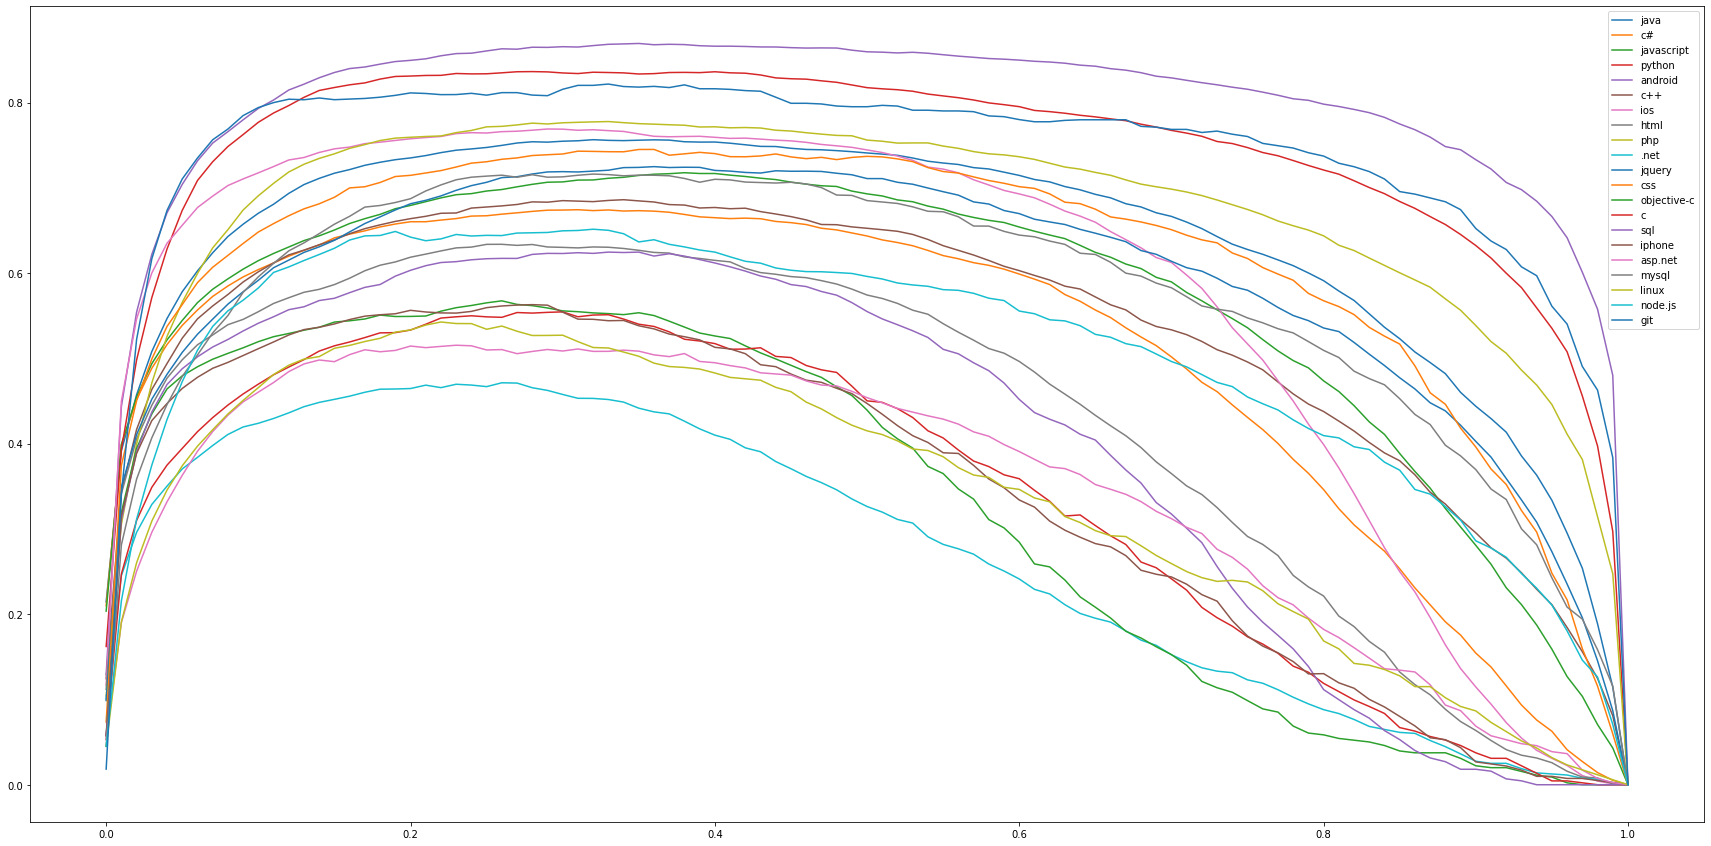

Sur le jeu test avec limit par tag:
              precision    recall  f1-score  support
android        0.885005  0.854279  0.869370   2045.0
python         0.838139  0.834609  0.836371   2612.0
git            0.845560  0.799270  0.821764    274.0
php            0.809302  0.748617  0.777778   1627.0
ios            0.703654  0.847826  0.769041   1840.0
java           0.742888  0.770658  0.756518   3558.0
css            0.753846  0.736516  0.745081   1131.0
jquery         0.721649  0.728218  0.724919   1538.0
javascript     0.676602  0.764303  0.717784   3356.0
mysql          0.729198  0.703650  0.716196    685.0
weighted avg   0.672580  0.739378  0.701473  33044.0
micro avg      0.659095  0.739378  0.696932  33044.0
c++            0.656584  0.718432  0.686117   1964.0
macro avg      0.652318  0.712069  0.677144  33044.0
c#             0.604010  0.763317  0.674383   3473.0
node.js        0.730419  0.587977  0.651503    682.0
html           0.544118  0.758974  0.633833   1755.0
sql       

In [33]:
%%time
if description["Word2Vec_keras"]["actif"]:
    best_limits_kerasword2vec = p5_nlp_utils.Commun.find_best_limit_by_tags(
        pred_kerasword2vec_proba, y_test, target_names, limits=np.linspace(0, 1, 101)
    )
    with open("/kaggle/working/best_limits_kerasword2vec.json", "w") as outfile:
        json.dump(best_limits_kerasword2vec, outfile)
    pred_kerasword2vec = p5_nlp_utils.Commun.convert_pred_to_bool_by_tags(pred_kerasword2vec_proba, {k: v[0] for k, v in best_limits_kerasword2vec.items()})
    scores_kerasword2vec = p5_nlp_utils.Commun.save_score(
        y_true=y_test,
        y_pred=pred_kerasword2vec,
        target_names=target_names,
        name="Word2Vec_keras",
    )
    print("Sur le jeu test avec limit par tag:")
    print(scores_kerasword2vec.sort_values(by="f1-score", ascending=False))

In [34]:
%%time
if description["Word2Vec_keras"]["actif"]:
    modelkerasPipeline.save("kerasWord2Vec")

2023-01-28 18:40:31.774057: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


CPU times: user 2.81 s, sys: 1.26 s, total: 4.07 s
Wall time: 4.08 s


## Word2Vec puis OvR SVC

In [35]:
%%time
pipeline_w2v = pipeline.Pipeline(
    [
        (
            "keras_embed_transformer",
            p5_nlp_utils.KerasEmbedTransformer().init(description["Word2Vec_OVR"]),
        ),
        (
            "OVR_SVC",
            multiclass.OneVsRestClassifier(
                svm.SVC(
                    cache_size=1080,
                    max_iter=description["Word2Vec_OVR"]["max_iter"],
                    random_state=42,
                )
            ),
        ),
    ]
)

if description["Word2Vec_OVR"]["actif"]:
    with ignore_warnings(category=exceptions.ConvergenceWarning):
        pipeline_w2v.fit(X_train, y_train)
#         pipeline_w2v.fit(X_train[0:10], y_train[0:10])

CPU times: user 142 µs, sys: 0 ns, total: 142 µs
Wall time: 147 µs


In [36]:
%%time
if description["Word2Vec_OVR"]["actif"]:
    pred_word2vec = pipeline_w2v.predict(X_test)
    print(pred_word2vec)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


### i got the same issue as:
https://stackoverflow.com/questions/37984304/how-to-save-a-scikit-learn-pipline-with-keras-regressor-inside-to-disk  
Solution is to save keras model in separate file than remove it from the pipeline so it can be save with joblib  
I did that in my `KerasEmbedTransformer` class `save` & `load` method

In [37]:
if description["Word2Vec_OVR"]["actif"]:
    pipeline_w2v.named_steps["keras_embed_transformer"].save("keras")
    # Otherwise i can save it but not load in api
    #     pipeline_w2v.named_steps["keras_embed_transformer"] = "passthrough"  # __module__
    #     pipeline_w2v.named_steps["keras_embed_transformer"].__module__ = None
    ## i have issue loading the joblib in api so i try to delete the step from the pipeline
    pipeline_w2v.steps.pop(0)
    pipeline_w2v.steps.insert(0, ("keras_embed_transformer", "passthrough"))
    print(pipeline_w2v)

In [38]:
if description["Word2Vec_OVR"]["actif"]:
    scores_word2vec = p5_nlp_utils.Commun.save_score(
        y_test, pred_word2vec, target_names, "Word2Vec"
    )
    joblib.dump(pipeline_w2v, "Word2Vec_model.joblib")
    print(scores_word2vec.sort_values(by="f1-score", ascending=False))

### test to reimport saved model

In [39]:
if description["Word2Vec_OVR"]["actif"] and LONG:
    loaded = joblib.load("/kaggle/working/Word2Vec_model.joblib")
    loaded.named_steps[
        "keras_embed_transformer"
    ] = p5_nlp_utils.KerasEmbedTransformer().load(
        "/kaggle/working/keras", description["Word2Vec_OVR"]
    )
    pred_word2vec == loaded.predict(X_test)

# BERT
Bidirectional Encoder Representations from Transformers  
[Article explication en français](https://www.quantmetry.com/glossaire/bert-nlp/)  
[Exemple multi-classification](https://www.analyticsvidhya.com/blog/2020/10/simple-text-multi-classification-task-using-keras-bert)

In [40]:
## check gpu
# import torch
# torch.cuda.is_available()

In [41]:
if description["BERT"]["actif"]:
    print(description["BERT"])
    configuration = BertConfig()
    print(configuration)

In [42]:
# %%time
# if description["BERT"]["actif"]:
#     tokenizer = p5_nlp_utils.Bert.get_tokenizer(
#         model_max_length=description["BERT"]["max_length"],
#         save_path="bert_base_uncased/",
#     )

In [43]:
%%time
if description["BERT"]["actif"]:
    X_train_bert = p5_nlp_utils.Bert.create_bert_inputs(
        X_train.values, max_len=description["BERT"]["max_length"]
    )
    print("Shape input BERT tupple 3*", X_train_bert[0].shape)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


In [44]:
%%time
if description["BERT"]["actif"]:
    #     bert_model = p5_nlp_utils.Bert.create_bert_model(
    #         params=description["BERT"], target_names=target_names
    #     )
    bert_model = p5_nlp_utils.Bert.build_bert_model(
        max_len=description["BERT"]["max_length"], target_names=target_names
    )
    print(bert_model.summary())

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [45]:
%%time
if description["BERT"]["actif"]:
    bert_model.fit(
        #         np.array(
        #             [create_bert_input_target(x, description["BERT"]) for x in X_train.values]
        #         ),
        X_train_bert,
        y_train,
        epochs=description["BERT"]["epochs"],
        verbose=3,
    )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [46]:
%%time
if description["BERT"]["actif"]:
    bert_model.save("BERT")
    #     pred_bert_proba = bert_model.predict(
    #         np.array(
    #             [create_bert_input_target(x, description["BERT"]) for x in X_test.values]
    #         )
    #     )
    pred_bert_proba = bert_model.predict(
        p5_nlp_utils.Bert.create_bert_inputs(
            X_test.values, max_len=description["BERT"]["max_length"]
        )
    )
    print(pred_bert_proba)
    best, f1_score_avg = p5_nlp_utils.Commun.find_best_limit(
        pred_bert_proba, y_test, target_names
    )
    pred_bert = p5_nlp_utils.Commun.convert_pred_to_bool(pred_bert_proba, limit=best)
    #     print(pred_bert.value_counts())
    scores_bert = p5_nlp_utils.Commun.save_score(
        y_test,
        pred_bert,
        target_names,
        None,
    )
    print(scores_bert.sort_values(by="f1-score", ascending=False))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


Test avec limit/seuil différent par tag

In [47]:
%%time
if description["BERT"]["actif"]:
    best_limits_bert = p5_nlp_utils.Commun.find_best_limit_by_tags(
        pred_bert_proba, y_test, target_names, limits=np.linspace(0, 1, 101)
    )
    with open("/kaggle/working/best_limits_bert.json", "w") as outfile:
        json.dump(best_limits_bert, outfile)
    pred_bert_2 = p5_nlp_utils.Commun.convert_pred_to_bool_by_tags(pred_bert_proba, {k: v[0] for k, v in best_limits_bert.items()})
    scores_bert_2 = p5_nlp_utils.Commun.save_score(
        y_true=y_test,
        y_pred=pred_bert_2,
        target_names=target_names,
        name="BERT",
    )
    print("Sur le jeu test avec limit par tag:")
    print(scores_bert_2.sort_values(by="f1-score", ascending=False))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [48]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# with tpu_strategy.scope():
# ...

In [49]:
# %%time
# model = BertTransformer(list(X_train[0:5]), params=description["BERT"])
# model

In [50]:
# %%time
# model = BertTransformer(list(X_train[0:50_000]), params=description["BERT"])
# # model = BertTransformer(list(X_train), params=description["BERT"])
# model
# # model.mean(axis=1)

# USE

In [51]:
%%time
if description["USE"]["actif"]:
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    X_train_use = embed(X_train.values)
    print(X_train_use.numpy().shape)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs


In [52]:
%%time
if description["USE"]["actif"]:
    USEkerasPipeline = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape=(512,)),  # tensor=X_train_use),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(len(target_names), activation="sigmoid"),
        ]
    )
    USEkerasPipeline.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )
    USEkerasPipeline.fit(
        X_train_use.numpy(),
        y_train,
        epochs=description["USE"]["epochs"],
        verbose=3,
    )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [53]:
%%time
if description["USE"]["actif"]:
    X_pred_test_use = USEkerasPipeline.predict(embed(X_test.values))
    #     print(X_pred_test_use)
    best, f1_score_avg = p5_nlp_utils.Commun.find_best_limit(
        X_pred_test_use, y_test, target_names, limits=np.linspace(0, 1, 101)
    )
    pred_use_bool = p5_nlp_utils.Commun.convert_pred_to_bool(
        X_pred_test_use, limit=best
    )
    use_pred_test_score = p5_nlp_utils.Commun.save_score(
        y_true=y_test,
        y_pred=pred_use_bool,
        target_names=target_names,
        name=None,
    )
    print("Sur le jeu test:")
    print(use_pred_test_score.sort_values(by="f1-score", ascending=False))
    USEkerasPipeline.save("kerasUSE")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


La limite optimal peut etre différente en fonction des tags:

In [54]:
%%time
if description["USE"]["actif"]:
    best_limits_use = p5_nlp_utils.Commun.find_best_limit_by_tags(
        X_pred_test_use, y_test, target_names, limits=np.linspace(0, 1, 101)
    )
#     print(best_limits_use)
    with open("/kaggle/working/best_limits_use.json", "w") as outfile:
        json.dump(best_limits_use, outfile)
        
    pred_use_bool_2 = p5_nlp_utils.Commun.convert_pred_to_bool_by_tags(X_pred_test_use, {k: v[0] for k, v in best_limits_use.items()})
    use_pred_test_score_2 = p5_nlp_utils.Commun.save_score(
        y_true=y_test,
        y_pred=pred_use_bool_2,
        target_names=target_names,
        name="kerasUSE",
    )
    print("Sur le jeu test avec limit par tag:")
    print(use_pred_test_score_2.sort_values(by="f1-score", ascending=False))

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 12.2 µs


In [55]:
# f1_scores = pd.DataFrame(
#     [
#         p5_nlp_utils.Commun.save_score(
#             y_true=y_test,
#             y_pred=p5_nlp_utils.Commun.convert_pred_to_bool(
#                 X_pred_test_use, limit=limit
#             ),
#             target_names=target_names,
#             name=None,
#         ).loc[target_names, "f1-score"]
#         for limit in np.linspace(0, 1, 101)
#     ],
#     index=np.linspace(0, 1, 101),
# )

In [56]:
if description["USE"]["actif"] and description["USE"]["tsne_visu"]:
    use_pred_train = USEkerasPipeline.predict(X_train_use)
    use_pred_train_bool = p5_nlp_utils.Commun.convert_pred_to_bool_by_tags(use_pred_train, {k: v[0] for k, v in best_limits_use.items()})
    use_pred_train_score = p5_nlp_utils.Commun.save_score(
        y_true=y_train, y_pred=use_pred_train_bool, target_names=target_names, name=None
    )
    print("Sur le jeu d'entrainement:")
    print(use_pred_train_score.sort_values(by="f1-score", ascending=False))

In [57]:
%%time
if description["USE"]["actif"] and description["USE"]["tsne_visu"]:
    X_train_use_tsne = p5_nlp_utils.Commun.calcul_tsne(X_train_use)
    print("Tag Réél:")
    p5_nlp_utils.Commun.visu_tsne(
        X_tsne=X_train_use_tsne,
        y_train_monodim=y_train_monodim,
        y_train=y_train,
        target_names=target_names,
        tag_list=[
            "java",
            "c#",
            "python",
            "android",
            "php",
            ".net",
            "mysql",
            "sql",
            "javascript",
            "jquery",
            "html",
            "node.js",
            "css",
            "c",
            "mysql",
            "linux",
            "git",
        ],
    )
    print("Tag prédit:")
    p5_nlp_utils.Commun.visu_tsne(
        X_tsne=X_train_use_tsne,
        y_train_monodim=y_train_monodim,
        y_train=use_pred_train_bool,
        target_names=target_names,
        tag_list=[
            "python",
            "java",
            "git",
            "android",
            "javascript",
            "css"
        ],
        maxcols=3,
    )

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


# LDA 

In [58]:
# import importlib

# importlib.reload(p5_nlp_utils)

In [59]:
import warnings

In [60]:
%%time
lda_models = {}
if description["LDA"]["actif"]:
    print(description["LDA"])
    X_train_tokens = X_train.str.split()
    nb_num_topics = len(description["LDA"]["num_topics"])
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    for indice, num_topics in enumerate(description["LDA"]["num_topics"]):
        print(f"Début {num_topics}topics ({indice+1}/{nb_num_topics})")
        lda_model = p5_nlp_utils.LDA(
            tokens=X_train_tokens,
            num_topics=num_topics,
            no_below=description["LDA"]["lda__no_below"],
            no_above=description["LDA"]["lda__no_above"],
            max_tokens=description["LDA"]["lda__max_tokens"],
            iterations=description["LDA"]["lda__iterations"],
        )
        print(f"Nommage des topis")
        lda_model.name_topics(target_names)
        # print(lda_model.topics_names)
        lda_model.word_cloud_by_topics(
            nb_words=description["LDA"]["word_cloud__nb_words"]
        )
        lda_models[indice] = lda_model.prepare_display()

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


### Affichage des topics avec pyLDAvis:

In [61]:
pyLDAvis.display(lda_models[0].display_data) if lda_models and lda_models.get(
    0, False
) else None

In [62]:
pyLDAvis.display(lda_models[1].display_data) if lda_models and lda_models.get(
    1, False
) else None

In [63]:
pyLDAvis.display(lda_models[2].display_data) if lda_models and lda_models.get(
    2, False
) else None

In [64]:
# pyLDAvis.prepared_data_to_html(lda_models[0].display_data)

In [65]:
%%time
if description["LDA"]["actif"]:
    lda_model = lda_models[list(lda_models.keys())[-1]]  # last
    pred_lda = lda_model.predict(X_test.str.split())
    print("Exemple prediction", pred_lda[0])
    pred_lda_bool = p5_nlp_utils.LDA.convert_pred(pred_lda, target_names)
    print(pred_lda_bool.head(1))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


In [66]:
%%time
if description["LDA"]["actif"]:
    lda_pred_test_score = p5_nlp_utils.Commun.save_score(
        y_true=y_test,
        y_pred=pred_lda_bool,
        target_names=target_names,
        name="LDA",
    )
    print("Sur le jeu test:")
    print(lda_pred_test_score.sort_values(by="f1-score", ascending=False))
    lda_model.model.save("LDA")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [67]:
# X_test.values[0]

In [68]:
# pred_lda[0]

In [69]:
# y_test.iloc[0]

In [70]:
def compare_topic_tags(
    pred_topic, y_true, tags=["java", "python", "javascript", "git"]
):
    """Pour chacun des tags, regarde les topics attribué quand ce tag est présent"""
    df_pred = pd.DataFrame(pred_topic)
    for tag in tags:
        print(f"***{colors.BOLD}{tag}{colors.ENDC}*** sur {sum(y_true[tag])} positif")
        display(
            df_pred[y_true[tag].values]
            .describe()
            .sort_values(by="count", ascending=False, axis="columns")
        )
        print("\n")

In [71]:
if description["LDA"]["actif"]:
    compare_topic_tags(pred_lda, y_test)